In [ ]:
from concurrent.futures import ProcessPoolExecutor
from multiprocessing import Pool
import traceback
import os
import pickle

import numpy as np
import pandas as pd
import multiprocessing
import matplotlib.pyplot as plt
from pydantic import BaseSettings, BaseModel
from joblib import Parallel, delayed

from scrap_optimization_xgboost import ScrapOptimization


class GeneralInfo(BaseModel):
    features:list
    target: str
    chemi_names: list
    train_dataset: str
    scrap_dataset: str
    chemi_dataset:str
    ML_MODELS:str
    violation_threshold:float

class SimulationInfo(BaseModel):
    id: int
    steel_type: str
    total_quantity:int
    epochs: int
    feature: int
    # def steel_type(self):
    #     return self.steel_type_const

class Settings(BaseSettings):
    general_info:GeneralInfo
    simulations: list[SimulationInfo]


settings = Settings.parse_file("settings.json")
simulations = settings.simulations
general_info = settings.general_info
supplier_quantity_hist = []
df_schrott = pd.read_csv(general_info.scrap_dataset)
df_schrott = df_schrott[df_schrott["name"].str.startswith("F")]
global_lock = multiprocessing.Lock()

# physical_devices = tf.config.list_physical_devices('CPU') 
# for device in physical_devices:
#     tf.config.experimental.set_memory_growth(device, True)


def run_simulation(simulation):
    simulation_settings,df_schrott,supplier_quantity_hist, sim_id_hist = simulation

    try: 
        global_lock.acquire()
        so= ScrapOptimization(general_info, simulation_settings)
        steel_chemi_df = pd.read_csv("assets/steel_chemi_components.csv")
        chemies = steel_chemi_df.loc[steel_chemi_df["name"] == float(simulation_settings.steel_type)]
        chemies = chemies[['C','Si','Mn','Cr','Mo','V']].values
        chemi_component = [float(i) for i in chemies[0]] 
        print(f"Running optimization for id:{simulation_settings.id}")
        simulation_settings.total_quantity = np.random.randint(5000, 7000)
        print(f"The toal quantity is {simulation_settings.total_quantity}")
        so.optimize(simulation_settings.total_quantity, chemi_component, simulation_settings.steel_type, df_schrott, supplier_quantity_hist,sim_id_hist)
        global_lock.release()
    except Exception as e:
        print("Error:")
        print(e)
        print(traceback.format_exc())


if __name__ == "__main__":
    # # print(settings)
    with multiprocessing.Manager() as manager:
        # lock = manager.Lock()
        supplier_quantity_hist = manager.list()
        sim_id_hist = manager.list()
        ns = manager.Namespace()
        ns.df_schrott = df_schrott

        simulations = [(item, ns, supplier_quantity_hist, sim_id_hist) for item in simulations]
        supplier_quantity_hist.append(ns.df_schrott["quantity"].to_list())
        core_count = 8
        with Pool(core_count) as p:
            p.map(run_simulation, simulations)

        print("len(supplier_quantity_hist): ",len(supplier_quantity_hist))
        all_hist = np.empty(shape=(0,len(supplier_quantity_hist)))
        fig, axes = plt.subplots(1,2, figsize=(15, 7))
        for idx, remote_scrap in enumerate(supplier_quantity_hist[0]):
            values = []
            for i in range(len(supplier_quantity_hist)):
                values.append(supplier_quantity_hist[i][idx])

            all_hist = np.vstack((all_hist, np.array(values).reshape(1,-1).copy()))


        for idx, row in enumerate(all_hist):
            if not np.all(np.isclose(row, row[0], atol=0.25)) and not np.all(row[:10]<1) and np.nan not in row:
                axes[0].plot(range(row.shape[0]), row, label=f"F{idx+1}",linewidth=0.5)
        np.save("npy/saved_plt.npy", all_hist)

        print(f"sim_id_hist= {[item for item in sim_id_hist]}")
        counts = [0]*8
        for item in sim_id_hist:
            counts[item-1] += 1

        axes[1].bar(range(core_count), counts)
        plt.savefig(f"sim_output/simulation_output_xgboost_ann.png")
        plt.show()

Running optimization for id:1
The toal quantity is 5202
[0.0153 0.003  0.0035 0.12   0.008  0.008 ]
epochs:  13
bounds_index: []
################# Optimizing for SLSQP iteration #################


2023-09-18 12:35:29.571363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/add_grad/Reshape/pfor/concat/loop_body/PartitionedCall/pfor/Reshape' with dtype int32 and shape [1]
	 [[{{node gradients/add_grad/Reshape/pfor/concat/loop_body/PartitionedCall/pfor/Reshape}}]]
2023-09-18 12:35:29.572779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/add_grad/Reshape/pfor/concat/loop_body/PartitionedCall/pfor/Reshape' with dtype int32 and shape [1]
	 [[{{node gradients/add_grad/Reshape/pfor/concat/loop_body/PartitionedCall/pfor/Reshape}}]]
2023-09-18 12:35:29.576007: I tensorflow/core/common_runtime/executo

################### original fremd schrotte ###################
[6090, 6490, 5050, 5390, 5840, 5770, 6530, 0, 8200, 7100, 8810, 9500, 6290, 8710, 0, 5690, 7120, 0, 7980, 7070, 8020, 5220, 6540, 9690, 9370, 5270, 8220, 0, 9110, 5540, 5330, 9740, 9850, 9610, 9440, 5180, 8530, 8500, 7920, 5050, 7310, 5260, 7310, 5060, 5380, 6120, 6990, 6670, 8610, 5600, 5440, 8930, 5650, 0, 5530, 6770, 6850, 8560, 9370, 6120, 5810, 8800, 6630, 8880, 6460, 7810, 8610, 7160, 5990, 0, 7540, 6280, 7990, 9730, 9900, 5930, 6880, 9710, 9070, 7410, 7740, 0, 7710, 9510, 5890, 6860, 6670, 8190, 9000, 5120, 6490, 6130, 8470, 5170, 8350, 9690, 0, 5430, 5280, 6760, 8650, 6880, 7440, 9720, 5760, 5070, 7530, 9070, 5730, 5680, 8960, 0, 9550, 6950, 7190, 9770, 7930, 5910, 6900, 8710, 6450, 7200, 8840, 0, 6220, 7400, 9320, 9780, 8170, 6490, 6030, 7560, 8890, 9290, 8160, 5350, 10000, 7520, 0, 8770, 5330, 5260, 5670, 9360, 7070, 6330, 8020, 6360, 6160, 9430, 9460, 6190, 8510, 0, 5720, 5350, 5530, 8350, 5710, 6930]
##########

In [4]:
import json

In [5]:
with open('buy_test/buy_list_1_04_.json', 'r') as f:
    data = json.load(f)

# Extract the list of dictionaries from the "opt_result" key
list_of_dicts = data.get("opt_result", [])

# Extract the values for "total_cost_True" and "total_cost_False"
total_cost_True_list = [item['total_cost_True'] for item in list_of_dicts if 'total_cost_True' in item]
total_cost_False_list = [item['total_cost_False'] for item in list_of_dicts if 'total_cost_False' in item]

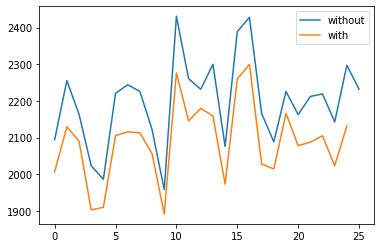

In [6]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(total_cost_True_list, label='without')
plt.plot(total_cost_False_list, label='with')
plt.legend()

In [7]:
np.mean(total_cost_True_list), np.mean(total_cost_False_list)

(2198.3860520988706, 2090.0239531610014)

## XGBOOST v.s. ANN

In [16]:
from scipy import stats

In [5]:
with open('buy_test/buy_list_xg_ann1_xgboost.json', 'r') as f:
    data = json.load(f)

# Extract the list of dictionaries from the "opt_result" key
list_of_dicts = data.get("opt_result", [])

In [13]:
methods = ["ann", "xgboost"]
losses_dict = {method: [result[method]['total_cost'] for result in list_of_dicts] for method in methods}
times_dict = {method: [result[method]['elapsed_time'] for result in list_of_dicts] for method in methods}

In [15]:
print("\nMean losses:")
for method in methods:
    print(f"{np.mean(losses_dict[method])}: {method}")
#
print("\nMean processing times:")
for method in methods:
    print(f"{np.mean(times_dict[method])}: {method}")


Mean losses:
1669.8605875881817: ann
1685.612138519834: xgboost

Mean processing times:
10.960556488770704: ann
40.301013212937576: xgboost


In [19]:
print("Two-sided t-test for equality of means between ANN and...")
print(f"{method}: {stats.ttest_rel(losses_dict['xgboost'], losses_dict['ann']).pvalue}")

Two-sided t-test for equality of means between ANN and...
xgboost: 0.14150951781295548
